In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/jamesmcgreevy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
data = 'paper'
#data = 'new'
#data = 'new_no_GFC'

if data == 'paper':
    # Paper data
    df_AMEX = pd.read_csv('Data/AMEX_01071962_31121999_with_out_shares.csv')
    df_NYSE = pd.read_csv('Data/NYSE_01071962_31121999_with_out_shares.csv')
else:
    # New data
    df_AMEX = pd.read_csv('Data/AMEX_01012000_31122022_with_out_shares.csv')
    df_NYSE = pd.read_csv('Data/NYSE_01012000_31122022_with_out_shares.csv')

# Define the start date of the dataset
if data == 'paper':
    # For the paper data this is Jul 1962
    start = (1962, 7)
else:
    # for new data this is Jan 2000
    start = (2000, 1)

# Are these all common shares? Hard to tell if there are any preference shares involved. Possibly share class might say but this usually means it is common

df_AMEX_NYSE = pd.concat([df_AMEX, df_NYSE], axis=0)

/Users/jamesmcgreevy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#there are a number of NA's where no price,volume or return data is available
df_AMEX_NYSE=df_AMEX_NYSE.dropna()

In [4]:
# Remove rows from df where return value was C
df_AMEX_NYSE = df_AMEX_NYSE[df_AMEX_NYSE['RET'] != 'C']

df_AMEX_NYSE

,PERMNO,date,EXCHCD,COMNAM,PRC,VOL,RET,SHROUT
0,10001,2009-12-18,2,ENERGY INC,8.38,77200.0,-0.031214,4361.0
1,10001,2009-12-21,2,ENERGY INC,9.46,136700.0,0.128878,4361.0
2,10001,2009-12-22,2,ENERGY INC,10.38,176000.0,0.097252,4361.0
3,10001,2009-12-23,2,ENERGY INC,10.30,44300.0,-0.007707,4361.0
4,10001,2009-12-24,2,ENERGY INC,10.72,37100.0,0.040777,4361.0
...,...,...,...,...,...,...,...,...
14694801,93427,2022-12-23,1,FABRINET,128.69,95497.0,0.002493,36587.0
14694802,93427,2022-12-27,1,FABRINET,129.55,132824.0,0.006683,36587.0
14694803,93427,2022-12-28,1,FABRINET,126.16,93662.0,-0.026167,36587.0
14694804,93427,2022-12-29,1,FABRINET,129.05,106454.0,0.022907,36587.0


In [5]:
# Do some tidying up. Create new columns for year and month
df_AMEX_NYSE['year'] = df_AMEX_NYSE['date'].apply(lambda x: x[:4])
df_AMEX_NYSE['month'] = df_AMEX_NYSE['date'].apply(lambda x: x[5:7])

# Change string values to float
df_AMEX_NYSE['PERMNO'] = df_AMEX_NYSE['PERMNO'].astype(int)
df_AMEX_NYSE['year'] = df_AMEX_NYSE['year'].astype(int)
df_AMEX_NYSE['month'] = df_AMEX_NYSE['month'].astype(int)
df_AMEX_NYSE['RET'] = df_AMEX_NYSE['RET'].astype(float)
df_AMEX_NYSE['PRC'] = df_AMEX_NYSE['PRC'].astype(float)
df_AMEX_NYSE['VOL'] = df_AMEX_NYSE['VOL'].astype(float)
df_AMEX_NYSE['SHROUT'] = df_AMEX_NYSE['SHROUT'].astype(float)

# Sort as looks nicer
df_AMEX_NYSE = df_AMEX_NYSE.sort_values(['PERMNO', 'date'])

In [6]:
df_AMEX_NYSE = df_AMEX_NYSE.set_index(['PERMNO', 'year', 'month', 'date'])

In [7]:
# Really important, from CRSP website: 'Sometimes you see negative stock prices in CRSP. This means that there was no closing price available for that period. 
# Instead the bid/ask average was used. To distinguish the bid/ask averages from actual closing prices, CRSP puts a leading dash in front of the price when the bid/ask average was used.'
# Hence we need to multiply any PRC with a dash in front by -1 to get a positive price
df_AMEX_NYSE[df_AMEX_NYSE['PRC'] <= 0]

df_AMEX_NYSE['PRC'] = df_AMEX_NYSE['PRC'].apply(lambda x: -x if x < 0 else x)

In [8]:
# Now that the prices are corrected, add column for dollar vol and market cap in millions
df_AMEX_NYSE['DOLLAR VOL'] = ((df_AMEX_NYSE['VOL'] * df_AMEX_NYSE['PRC']) / 1_000_000)
df_AMEX_NYSE['MKT CAP'] = ((df_AMEX_NYSE['PRC'] * df_AMEX_NYSE['SHROUT']) / 1_000_000)

In [9]:
df_AMEX_NYSE

EXCHCD      COMNAM     PRC       VOL       RET  \
PERMNO year month date                                                         
10001  2009 12    2009-12-18       2  ENERGY INC    8.38   77200.0 -0.031214   
                  2009-12-21       2  ENERGY INC    9.46  136700.0  0.128878   
                  2009-12-22       2  ENERGY INC   10.38  176000.0  0.097252   
                  2009-12-23       2  ENERGY INC   10.30   44300.0 -0.007707   
                  2009-12-24       2  ENERGY INC   10.72   37100.0  0.040777   
...                              ...         ...     ...       ...       ...   
93427  2022 12    2022-12-23       1    FABRINET  128.69   95497.0  0.002493   
                  2022-12-27       1    FABRINET  129.55  132824.0  0.006683   
                  2022-12-28       1    FABRINET  126.16   93662.0 -0.026167   
                  2022-12-29       1    FABRINET  129.05  106454.0  0.022907   
                  2022-12-30       1    FABRINET  128.22   89389.0 -0.006432   

                               SHROUT  DOLLAR VOL   MKT CAP  
PERMNO year month date                                       
10001  2009 12    2009-12-18   4361.0    0.646936  0.036545  
                  2009-12-21   4361.0    1.293182  0.041255  
                  2009-12-22   4361.0    1.826880  0.045267  
                  2009-12-23   4361.0    0.456290  0.044918  
                  2009-12-24   4361.0    0.397712  0.046750  
...                               ...         ...       ...  
93427  2022 12    2022-12-23  36587.0   12.289509  4.708381  
                  2022-12-27  36587.0   17.207349  4.739846  
                  2022-12-28  36587.0   11.816398  4.615816  
                  2022-12-29  36587.0   13.737889  4.721552  
                  2022-12-30  36587.0   11.461458  4.691185  

[17962142 rows x 8 columns]

In [10]:
if data == 'new_no_GFC':
    # Remove Great Financial Crisis years
    df_AMEX_NYSE = df_AMEX_NYSE.drop(2007, level=1)
    df_AMEX_NYSE = df_AMEX_NYSE.drop(2008, level=1)
    df_AMEX_NYSE = df_AMEX_NYSE.drop(2009, level=1)

"if data == 'new_no_GFC':\n    # Remove Great Financial Crisis years\n    df_AMEX_NYSE = df_AMEX_NYSE.drop(2007, level=1)\n    df_AMEX_NYSE = df_AMEX_NYSE.drop(2008, level=1)\n    df_AMEX_NYSE = df_AMEX_NYSE.drop(2009, level=1)"

In [11]:
# At this point we have one dataframe: our original df_AMEX_NYSE df
# Here we diverge as the market portfolio and illiquidity portfolios require different conditions on their respective stocks, and different measures of illiquidity
# We start with the market portfolios

In [12]:
# Make a copy of df_AMEX_NYSE to maintain its integrity
df_AMEX_NYSE_market = df_AMEX_NYSE

In [13]:
# We remove any stock with beginning of the month price outside the range of (5, 1000)
rows_to_delete_on_price = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    if (5 <= row_one['PRC'] <= 1000) == False:
        rows_to_delete_on_price.append((name, year, month))

# We drop them from our main dataframe. This will help us form the market portfolio shortly
index_names = df_AMEX_NYSE_market.index.names[:3]
df_AMEX_NYSE_market = df_AMEX_NYSE_market.reset_index().set_index(index_names)
df_AMEX_NYSE_market = df_AMEX_NYSE_market.drop(index=rows_to_delete_on_price)

In [14]:
# This is ok since the price at the start of the month was in fact 877
df_AMEX_NYSE_market[df_AMEX_NYSE_market['PRC'] >= 1000]

# This is ok since the price at the start of the month was in fact above 5 (double check)
df_AMEX_NYSE_market[df_AMEX_NYSE_market['PRC'] <= 5]

date  EXCHCD                 COMNAM     PRC  \
PERMNO year month                                                      
10028  2007 12     2007-12-17       2  D G S E COMPANIES INC  4.9499   
            12     2007-12-18       2  D G S E COMPANIES INC  5.0000   
            12     2007-12-19       2  D G S E COMPANIES INC  5.0000   
       2008 1      2008-01-03       2  D G S E COMPANIES INC  5.0000   
            1      2008-01-04       2  D G S E COMPANIES INC  5.0000   
...                       ...     ...                    ...     ...   
93420  2019 7      2019-07-31       1    OASIS PETROLEUM INC  4.8700   
93422  2019 7      2019-07-25       1    Q E P RESOURCES INC  4.8400   
            7      2019-07-26       1    Q E P RESOURCES INC  4.8200   
            7      2019-07-29       1    Q E P RESOURCES INC  4.7200   
            7      2019-07-31       1    Q E P RESOURCES INC  4.9500   

                          VOL       RET    SHROUT  DOLLAR VOL   MKT CAP  
PERMNO year month                                                        
10028  2007 12         9500.0 -0.038854    9900.0    0.047024  0.049004  
            12         9900.0  0.010121    9900.0    0.049500  0.049500  
            12         6100.0  0.000000    9900.0    0.030500  0.049500  
       2008 1          2900.0 -0.040307    9900.0    0.014500  0.049500  
            1          1700.0  0.000000    9900.0    0.008500  0.049500  
...                       ...       ...       ...         ...       ...  
93420  2019 7      11288727.0 -0.004090  322032.0   54.976100  1.568296  
93422  2019 7      10551399.0 -0.081594  238045.0   51.068771  1.152138  
            7       7513586.0 -0.004132  238045.0   36.215485  1.147377  
            7       6515326.0 -0.020747  238045.0   30.752339  1.123572  
            7       5213951.0 -0.025591  238045.0   25.809057  1.178323  

[98469 rows x 9 columns]

In [15]:
# Get the number of valid observation days in each month
df_valid_obs_days = df_AMEX_NYSE_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# The paper only uses stocks for which they have at least 15 days per month of valid values
rows_to_delete_too_few_obs = []

for (name, year, month) in df_valid_obs_days.index:
    if (df_valid_obs_days.loc[(name, year, month)] < 15):
        rows_to_delete_too_few_obs.append((name, year, month))

# We drop them from our main dataframe as well. This will help us form the market portfolio shortly
df_AMEX_NYSE_market = df_AMEX_NYSE_market.drop(index=rows_to_delete_too_few_obs)

In [16]:
# Now find illiquidity of each stock
# Begin by finding daily illquidity of all stocks

# Get the number of valid observation days in each month. Have to do this again as a number of stocks were dropped when we last used this method
df_valid_obs_days = df_AMEX_NYSE_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# Create a column of ratio of return to dollar volume. On the days where volume is zero, do we still include that day as a valid observation day? 
# We cant divide by zero so we have to set that value to 0 in the sum rather than +/- inf
df_AMEX_NYSE_market['ILLIQUIDITY'] = np.abs(df_AMEX_NYSE_market['RET']) / df_AMEX_NYSE_market['DOLLAR VOL']
df_AMEX_NYSE_market['ILLIQUIDITY'] = df_AMEX_NYSE_market['ILLIQUIDITY'].fillna(0)
df_AMEX_NYSE_market['ILLIQUIDITY'] = df_AMEX_NYSE_market['ILLIQUIDITY'].replace([np.inf, -np.inf], 0)

# Create a series with just the illiquidity sum for each valid month
df_illiquidity_sum = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].sum()
df_illiquidity_var = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].var()
df_illiquidity_sum.to_frame()

ILLIQUIDITY
PERMNO year month             
10001  2010 1         1.470462
            2         2.340999
            3         1.079691
            4         2.039416
            5         2.000997
...                        ...
93427  2022 8         0.025385
            9         0.022053
            10        0.024234
            11        0.013096
            12        0.016288

[739005 rows x 1 columns]

In [17]:
# We can now compute illiquidity values for each stock for each month of each year
df_illiquidity_market = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_illiquidity_market = df_illiquidity_market.to_frame()
df_illiquidity_var = df_illiquidity_var.to_frame()
df_illiquidity_market = df_illiquidity_market.rename(columns={0: 'ILLIQUIDITY'})
df_illiquidity_market['ILLIQ VAR'] = df_illiquidity_var['ILLIQUIDITY']

In [18]:
# We need to find the return of the market portfolio for each month t. We assume equal weights for now but can amend later if need be.
# First step is to gather the data into year, month combinations
# We also return the market caps as we will need them shortly for illiquidity calcs
AMEX_NYSE_monthly_prices = []
AMEX_NYSE_monthly_caps = []
new_index = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    row_last = group.iloc[len(group) - 1]
    new_index.append((name, year, month))
    AMEX_NYSE_monthly_prices.append(row_one)
    AMEX_NYSE_monthly_caps.append(row_last)

df_AMEX_NYSE_monthly_prices = pd.DataFrame(AMEX_NYSE_monthly_prices, index=new_index, columns=df_AMEX_NYSE.columns)
df_AMEX_NYSE_monthly_caps = pd.DataFrame(AMEX_NYSE_monthly_caps, index=new_index, columns=df_AMEX_NYSE.columns)

In [19]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_monthly_prices.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_prices.index, names=['PERMNO', 'year', 'month'])

# Get each stock's monthly return
df_AMEX_NYSE_monthly_prices['MONTHLY RETURNS'] = df_AMEX_NYSE_monthly_prices.groupby(['PERMNO'])['PRC'].pct_change()

# Now we have a dataframe with just the last data of each month for each year for each stock
df_AMEX_NYSE_monthly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_caps.index, names=['PERMNO', 'year', 'month'])

In [20]:
# We get the returns of our market portfolios for each month of each year
df_AMEX_NYSE_monthly_portfolios = df_AMEX_NYSE_monthly_prices.groupby(['year', 'month'])

monthly_portfolio_returns = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolios:
    new_index.append((year, month))
    col = group['MONTHLY RETURNS']
    L = len(col)
    ret = col.values/L
    ret = np.nansum(ret, axis=0)
    monthly_portfolio_returns.append(ret)

df_AMEX_NYSE_monthly_portfolio_returns = pd.DataFrame(monthly_portfolio_returns, index=new_index, columns=['RET'])

# Now we have the market portfolio monthly returns by equal weight
df_AMEX_NYSE_monthly_portfolio_returns.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolio_returns.index, names=['year', 'month'])

In [21]:
# Now we get monthly market cap ratios as defined in the paper, assumed equal weight
df_AMEX_NYSE_monthly_portfolio_caps = df_AMEX_NYSE_monthly_caps.groupby(['year', 'month'])

monthly_portfolio_caps = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolio_caps:
    new_index.append((year, month))
    col = group['MKT CAP']
    L = len(col)
    cap = col.values/L
    #cap = col.values/col.sum()
    cap = np.nansum(cap)
    monthly_portfolio_caps.append(cap)

df_AMEX_NYSE_monthly_portfolio_caps = pd.DataFrame(monthly_portfolio_caps, index=new_index, columns=['CAP'])

In [22]:
# Now we have the market portfolio monthly caps by equal weight
df_AMEX_NYSE_monthly_portfolio_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolio_caps.index, names=['year', 'month'])

# We now need the cap ratios to the cap of July 1962
base = df_AMEX_NYSE_monthly_portfolio_caps.loc[start, 'CAP']

# We compute the ratio of the current market cap to that of July 1962
df_AMEX_NYSE_monthly_portfolio_caps['RATIO'] = df_AMEX_NYSE_monthly_portfolio_caps['CAP'] / base

In [23]:
'''# Now we can find the illiquidity adjustments c as described in the paper
# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe
# We wont be working with the returns and c from 1962, so its ok for its values in July to be incorrect
# This is super slow

df_illiquidity_market['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_illiquidity_market))

for index in df_illiquidity_market.index:
    pos = index[1:3]

    if (pos == start):
        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY']
    else:
        i = df_AMEX_NYSE_monthly_portfolio_caps.index.get_loc(pos)
        ratio = df_AMEX_NYSE_monthly_portfolio_caps.iloc[i - 1, 1]
        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY'] * ratio'''


"# Now we can find the illiquidity adjustments c as described in the paper\n# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe\n# We wont be working with the returns and c from 1962, so its ok for its values in July to be incorrect\n# This is super slow\n\ndf_illiquidity_market['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_illiquidity_market))\n\nfor index in df_illiquidity_market.index:\n    pos = index[1:3]\n\n    if (pos == start):\n        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY']\n    else:\n        i = df_AMEX_NYSE_monthly_portfolio_caps.index.get_loc(pos)\n        ratio = df_AMEX_NYSE_monthly_portfolio_caps.iloc[i - 1, 1]\n        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY'] * ratio"

In [24]:
'''# Now we can compute c
df_illiquidity_market['c'] = np.minimum(0.25 + 0.3 * df_illiquidity_market['ADJUSTED ILLIQUIDITY'], 30.)

# Saving illiquidity values
if data == 'paper':
    # Takes a long time so just read in instead for paper data
    df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market.csv')
elif data == 'new':
    # Takes a long time so just read in instead for new data
    df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market_new_data.csv')
else:
    # Takes a long time so just read in instead for new data with no GFC
    df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market_new_data_no_2008.csv')'''

"# Now we can compute c\ndf_illiquidity_market['c'] = np.minimum(0.25 + 0.3 * df_illiquidity_market['ADJUSTED ILLIQUIDITY'], 30.)\n\n# Saving illiquidity values\nif data == 'paper':\n    # Takes a long time so just read in instead for paper data\n    df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market.csv')\nelif data == 'new':\n    # Takes a long time so just read in instead for new data\n    df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market_new_data.csv')\nelse:\n    # Takes a long time so just read in instead for new data with no GFC\n    df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market_new_data_no_2008.csv')"

In [25]:
# Reading in illiquidity values
if data == 'paper':
    # Takes a long time so just read in instead for paper data
    df_illiquidity_market = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_market.csv', index_col=['PERMNO', 'year', 'month'])
elif data == 'new':
    # Takes a long time so just read in instead for new data
    df_illiquidity_market = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_market_new_data.csv', index_col=['PERMNO', 'year', 'month'])
else:
    # Takes a long time so just read in instead for new data with no GFC
    df_illiquidity_market = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_market_new_data_no_2008.csv', index_col=['PERMNO', 'year', 'month'])

In [26]:
df_illiquidity_market = df_illiquidity_market.join(df_AMEX_NYSE_monthly_caps['MKT CAP'], on=['PERMNO', 'year', 'month'])

In [27]:
# Now we can find the illiquidity for each market portfolio for each month of each year
df_AMEX_NYSE_monthly_portfolios_illiquidity = df_illiquidity_market.groupby(['year', 'month'])

monthly_portfolio_illiquidity = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolios_illiquidity:
    new_index.append((year, month))
    col = group['c']
    L = len(col)
    c = col.values/L
    c = np.nansum(c, axis=0)
    monthly_portfolio_illiquidity.append(c)

df_AMEX_NYSE_monthly_portfolios_illiquidity = pd.DataFrame(monthly_portfolio_illiquidity, index=new_index, columns=['c'])

# Now we have the market portfolio monthly returns by equal weight
df_AMEX_NYSE_monthly_portfolios_illiquidity.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolios_illiquidity.index, names=['year', 'month'])

In [28]:
# We combine the market portfolios values into one dataframe
df_AMEX_NYSE_monthly_portfolio_returns['c'] = df_AMEX_NYSE_monthly_portfolios_illiquidity['c']
df_AMEX_NYSE_market_portfolios = df_AMEX_NYSE_monthly_portfolio_returns
df_AMEX_NYSE_market_portfolios

RET         c
year month                    
2000 1      0.000000  0.301672
     2     -0.003005  0.303837
     3      0.002018  0.300734
     4      0.044894  0.319543
     5     -0.000219  0.319118
...              ...       ...
2022 8      0.062821  0.281112
     9     -0.032883  0.283802
     10    -0.063352  0.284153
     11     0.063741  0.288703
     12     0.046153  0.288304

[276 rows x 2 columns]

In [29]:
df_AMEX_NYSE_monthly_portfolio_caps['ADJUSTED RATIO'] = (30. - 0.25) / (0.3 * df_AMEX_NYSE_monthly_portfolio_caps['RATIO'].shift(1))

df_illiquidity_market_grouped = df_illiquidity_market.groupby(['year', 'month'])
monthly_market_portfolio_unnormalized_illiq = []
new_index = []

for (year, month), group in df_illiquidity_market_grouped:
    new_index.append((year, month))
    
    # Get the illiq of the market portfolio for each month
    illiquidities = group['ILLIQUIDITY']
    caps = group['MKT CAP']
    L = len(illiquidities)
    #print(L)

    # Get the adjusted ratio of the respective month
    adjusted_ratio = df_AMEX_NYSE_monthly_portfolio_caps.loc[(year, month), 'ADJUSTED RATIO']
    #total_cap = df_AMEX_NYSE_monthly_portfolio_caps.loc[(year, month), 'CAP']
    #total_cap = caps.sum()
    adjusted_ratio_arr = np.ones(L) * adjusted_ratio

    #w = caps / total_cap

    # Compare the arrays to find the minimum of the adjusted ratio and the illiquidity
    unnormalized_illiquidities = np.minimum(illiquidities.values, adjusted_ratio_arr)
    
    # This is for value weights
    #illiq = illiquidities * w
    
    # This is for equal weights
    illiq = illiquidities/L
    illiq = np.nansum(illiq, axis=0)
    monthly_market_portfolio_unnormalized_illiq.append(illiq)

df_AMEX_NYSE_monthly_portfolio_caps['ILLIQ_bar'] = monthly_market_portfolio_unnormalized_illiq

In [30]:
df_AMEX_NYSE_monthly_portfolio_caps

CAP     RATIO  ADJUSTED RATIO  ILLIQ_bar
year month                                                
2000 1       3.855993  1.000000             NaN   0.172239
     2       3.754810  0.973760       99.166667   0.179455
     3       4.105856  1.064799      101.838971   0.173672
     4       4.110191  1.065923       93.131846   0.217702
     5       4.102985  1.064054       93.033635   0.216143
...               ...       ...             ...        ...
2022 8      11.121159  2.884123       33.124749   0.034641
     9      10.199778  2.645175       34.383645   0.039067
     10     11.456926  2.971200       37.489637   0.043038
     11     12.061830  3.128074       33.375966   0.043420
     12     11.551586  2.995749       31.702152   0.040818

[276 rows x 4 columns]

In [31]:
def residual_c(df):
    #Now perform regression

    #temp name for easy of reading
    x=df

    y=0.25+0.3*x['ILLIQ_bar']*x['RATIO']#.shift(1)
    x1=0.25+0.3*x['ILLIQ_bar'].shift(1)*x['RATIO'].shift(1)
    x2=0.25+0.3*x['ILLIQ_bar'].shift(2)*x['RATIO'].shift(1)

    y=y[2:] #remove observation with NA's in X

    #now do regression
    #(XTX)^-1(xTY)
    x0=np.ones(x1.shape)
    xs=pd.DataFrame(x0,columns=['x0'],index=x1.index)
    xs['x1']=x1
    xs['x2']=x2

    xs=xs.dropna()

    coefs=np.linalg.inv(xs.T@xs).dot(np.dot(xs.T,y)).T

    #Now estimate residuals

    xs['y_hat']=(xs*coefs).sum(axis=1)
    xs['resid']=y-xs['y_hat']

    return xs

In [32]:
market_regression_residual = residual_c(df_AMEX_NYSE_monthly_portfolio_caps)

In [33]:
market_regression_residual[16:]

x0        x1        x2     y_hat     resid
year month                                             
2001 7      1.0  0.301129  0.297442  0.297130 -0.001876
     8      1.0  0.295254  0.300977  0.297089 -0.000256
     9      1.0  0.296833  0.293045  0.297081  0.010156
     10     1.0  0.307237  0.293774  0.297173  0.007678
     11     1.0  0.304851  0.308788  0.297194  0.007756
...         ...       ...       ...       ...       ...
2022 8      1.0  0.286886  0.285527  0.296974 -0.017001
     9      1.0  0.279973  0.285535  0.296914 -0.015912
     10     1.0  0.281002  0.277490  0.296901 -0.008538
     11     1.0  0.288363  0.284823  0.296985 -0.006238
     12     1.0  0.290746  0.290388  0.297021 -0.010337

[258 rows x 5 columns]

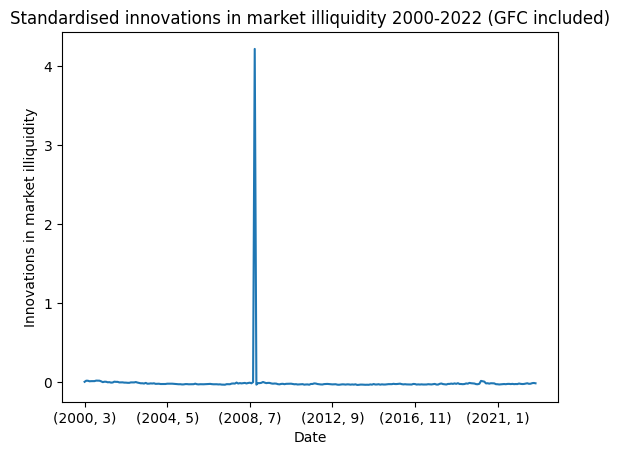

In [79]:
vals = market_regression_residual['resid'].loc[start:]
vals.plot()
plt.title('Standardised innovations in market illiquidity 1964-1999')
plt.xlabel('Date')
plt.ylabel('Innovations in market illiquidity')
plt.show()

In [35]:
def residual_returns(df):
    regression_data=df.groupby(['year','month']).sum()
    #perform regression on market portfolio against itself one period earlier
    y=regression_data['RET']
    x1=regression_data['RET'].shift(1)
    x2=regression_data['RET'].shift(2)

    y=y[2:] 

    #now do regression
    #(XTX)^-1(xTY)
    x0=np.ones(x1.shape)
    xs=pd.DataFrame(x0,columns=['x0'],index=x1.index)
    xs['x1']=x1
    xs['x2']=x2

    xs=xs.dropna()

    coefs=np.linalg.inv(xs.T@xs).dot(np.dot(xs.T,y)).T

    #Now estimate residuals

    xs['y_hat']=(xs*coefs).sum(axis=1)
    xs['resid']=y-xs['y_hat']

    return xs

    #missing last entry as this would require knowing the future market value I think

In [36]:
market_portfolio_regression=residual_returns(df_AMEX_NYSE_market_portfolios)

In [37]:
market_portfolio_regression

x0        x1        x2     y_hat     resid
year month                                             
2000 3      1.0 -0.003005  0.000000  0.007350 -0.005331
     4      1.0  0.002018 -0.003005  0.007790  0.037104
     5      1.0  0.044894  0.002018  0.008927 -0.009146
     6      1.0 -0.000219  0.044894  0.003608 -0.006028
     7      1.0 -0.002420 -0.000219  0.007390  0.009118
...         ...       ...       ...       ...       ...
2022 8      1.0 -0.074074  0.003237  0.004475  0.058346
     9      1.0  0.062821 -0.074074  0.016096 -0.048979
     10     1.0 -0.032883  0.062821  0.000880 -0.064232
     11     1.0 -0.063352 -0.032883  0.007959  0.055782
     12     1.0  0.063741 -0.063352  0.015212  0.030941

[274 rows x 5 columns]

In [38]:
# Now we move on to our illiquidity sorted portfolios. For now lets just do the portfolio sorted by illiquidity value rather than it and the variance and cap sorted portfolios

In [39]:
# Again, copy our new dataframe to maintain its integrity
df_AMEX_NYSE_non_market = df_AMEX_NYSE

In [40]:

if data == 'paper':
    # We are only working with data from 1963 now so we drop any data from 1962
    df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.drop(1962, level=1)

"\nif data == 'paper':\n    # We are only working with data from 1963 now so we drop any data from 1962\n    df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.drop(1962, level=1)"

In [41]:
# We remove any stock with beginning of the year price outside the range of (5, 1000)
rows_to_delete_on_price = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])
for (name, year), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    if (5 <= row_one['PRC'] <= 1000) == False:
        rows_to_delete_on_price.append((name, year))

# We drop them from our main dataframe. This will help us form the new portfolios shortly
index_names = df_AMEX_NYSE_non_market.index.names[:2]
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.reset_index().set_index(index_names)
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.drop(index=rows_to_delete_on_price)

In [42]:
# We return the market caps as we will need them shortly for portfolio sorting. This time the caps are based on yearly caps
AMEX_NYSE_yearly_caps = []
new_index = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])
for (name, year), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    new_index.append((name, year))
    AMEX_NYSE_yearly_caps.append(row_one)

df_AMEX_NYSE_non_market_yearly_caps = pd.DataFrame(AMEX_NYSE_yearly_caps, index=new_index, columns=df_AMEX_NYSE_non_market.columns)

In [43]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_non_market_yearly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_yearly_caps.index, names=['PERMNO', 'year'])

In [44]:
# Get the number of valid observation days in each month
df_valid_obs_days = df_AMEX_NYSE_non_market.groupby(level=['PERMNO', 'year'])['date'].count()
df_valid_obs_days.to_frame()

# Now find annual illiquidity of all stocks
# Begin by finding daily illquidity of all stocks

# Create a column of ratio of return to dollar volume. On the days where volume is zero, do we still include that day as a valid observation day? 
# We cant divide by zero so we have to set that value to 0 in the sum rather than +/- inf
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = np.abs(df_AMEX_NYSE_non_market['RET']) / df_AMEX_NYSE_non_market['DOLLAR VOL']
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = df_AMEX_NYSE_non_market['ILLIQUIDITY'].fillna(0)
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = df_AMEX_NYSE_non_market['ILLIQUIDITY'].replace([np.inf, -np.inf], 0)

# Create a series with just the illiquidity sum for each valid year
df_illiquidity_sum = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])['ILLIQUIDITY'].sum()
df_illiquidity_var = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])['ILLIQUIDITY'].var()
df_illiquidity_sum.to_frame()
df_illiquidity_var = df_illiquidity_var.to_frame()

In [45]:
# We can now compute illiquidity values for each stock for each year
df_illiquidity_non_market = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_illiquidity_non_market = df_illiquidity_non_market.to_frame()
df_illiquidity_non_market = df_illiquidity_non_market.rename(columns={0: 'ILLIQUIDITY'})

# Each year's liquidity value is actually the previous full year's, as we are sorting based on year t - 1, so we shift the dataframe
df_illiquidity_non_market = df_illiquidity_non_market.shift()
df_illiquidity_non_market_var = df_illiquidity_var.shift()

In [46]:
# The paper only uses stocks for which they have at least 100 days in the last year of valid values
rows_to_delete_too_few_obs = []

for (name, year) in df_valid_obs_days.index:
    current_row_num = df_valid_obs_days.index.get_loc((name, year))
    if (current_row_num == 0):
        rows_to_delete_too_few_obs.append((name, year))
    else:
        row_num_minus_one = current_row_num - 1
        row_num_minus_one_name = df_valid_obs_days.index[row_num_minus_one][0]
        row_num_minus_one_days = df_valid_obs_days.iloc[row_num_minus_one]

        if (name == row_num_minus_one_name):
            if (row_num_minus_one_days < 100):
                rows_to_delete_too_few_obs.append((name, year))
        else:
            rows_to_delete_too_few_obs.append((name, year))

# We drop them from our main dataframe as well. This will help us form the market portfolio shortly
df_illiquidity_non_market = df_illiquidity_non_market.drop(index=rows_to_delete_too_few_obs)
df_illiquidity_non_market_var = df_illiquidity_non_market_var.drop(index=rows_to_delete_too_few_obs)

In [47]:
df_illiquidity_non_market #this is yearly illiquidity, we also need monthly now

ILLIQUIDITY
PERMNO year             
10001  2011     0.095409
       2012     0.046200
       2013     0.059409
       2014     0.034792
       2015     0.019535
...                  ...
93427  2018     0.000758
       2019     0.001083
       2020     0.000946
       2021     0.001344
       2022     0.001053

[56814 rows x 1 columns]

In [48]:
# Group the dataframe by years
df_illiquidity_non_market_year_group = df_illiquidity_non_market.groupby('year')
df_illiquidity_non_market_var_year_group = df_illiquidity_non_market_var.groupby('year')
df_AMEX_NYSE_non_market_yearly_caps_group = df_AMEX_NYSE_non_market_yearly_caps.groupby('year')

In [49]:
# Now we sort into the correct portfolios
# create an empty list to store the split dataframes
df_non_market_increasing_yearly_illiquidity_portfolios = []

# loop over each group
for name, group in df_illiquidity_non_market_year_group:
    # sort the group
    sorted_group = group.sort_values('ILLIQUIDITY')
    # divide the sorted group into 25 equal parts
    split_group = np.array_split(sorted_group, 25)
    # append the split group to the list of split dataframes
    df_non_market_increasing_yearly_illiquidity_portfolios += split_group

In [50]:
# We need to find the return of the portfolio for each month t. We assume equal weights for now but can amend later if need be.
# First step is to gather the data into year, month combinations
# We also return the market caps as we will need them shortly for illiquidity calcs
AMEX_NYSE_monthly_prices = []
AMEX_NYSE_monthly_caps = []
new_index = []

df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.reset_index().set_index(['PERMNO', 'year', 'month'])
df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    row_last = group.iloc[len(group) - 1]
    new_index.append((name, year, month))
    AMEX_NYSE_monthly_prices.append(row_one)
    AMEX_NYSE_monthly_caps.append(row_last)

df_AMEX_NYSE_non_market_monthly_prices = pd.DataFrame(AMEX_NYSE_monthly_prices, index=new_index, columns=df_AMEX_NYSE_non_market.columns)
df_AMEX_NYSE_non_market_monthly_caps = pd.DataFrame(AMEX_NYSE_monthly_caps, index=new_index, columns=df_AMEX_NYSE_non_market.columns)

In [51]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_non_market_monthly_prices.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_prices.index, names=['PERMNO', 'year', 'month'])

# Now we have a dataframe with just the last data of each month for each year for each stock
df_AMEX_NYSE_non_market_monthly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_caps.index, names=['PERMNO', 'year', 'month'])

# Get each stock's monthly return
df_AMEX_NYSE_non_market_monthly_prices['MONTHLY RETURNS'] = df_AMEX_NYSE_non_market_monthly_prices.groupby(['PERMNO'])['PRC'].pct_change()

In [52]:
# We now have to repeat this proceedure for the adjusted illiquidity values c. To do this we bring over the functions used in the other ipynb. Note: the calculation for adjusted illiquidity takes a very long time

# Now we get monthly market cap ratios as defined in the paper
df_AMEX_NYSE_non_market_monthly_portfolio_caps = df_AMEX_NYSE_non_market_monthly_caps.groupby(['year', 'month'])

monthly_portfolio_caps = []
new_index = []

for (year, month), group in df_AMEX_NYSE_non_market_monthly_portfolio_caps:
    new_index.append((year, month))
    col = group['MKT CAP']
    L = len(col)
    cap = col.values/L
    cap = np.nansum(cap)
    monthly_portfolio_caps.append(cap)

df_AMEX_NYSE_non_market_monthly_portfolio_caps = pd.DataFrame(monthly_portfolio_caps, index=new_index, columns=['CAP'])

In [53]:
# Now we have the market portfolio monthly caps by equal weight
df_AMEX_NYSE_non_market_monthly_portfolio_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_portfolio_caps.index, names=['year', 'month'])

In [54]:
# We now need the cap ratios to the cap of start date
base = df_AMEX_NYSE_monthly_portfolio_caps.loc[start, 'CAP']
# For old data
#base = 0.19308631191927988
df_AMEX_NYSE_non_market_monthly_portfolio_caps['RATIO'] = df_AMEX_NYSE_non_market_monthly_portfolio_caps['CAP'] / base

In [55]:
# Now find market portfolio illiquidity
# Begin by finding daily illquidity of all stocks

# Get the number of valid observation days in each month. Have to do this again as a number of stocks were dropped when we last used this method
df_valid_obs_days = df_AMEX_NYSE_non_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# Create a series with just the illiquidity sum for each valid month
df_illiquidity_sum = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].sum()
df_illiquidity_sum.to_frame()

ILLIQUIDITY
PERMNO year month             
10001  2009 12        0.642537
       2010 1         1.470462
            2         2.340999
            3         1.079691
            4         2.039416
...                        ...
93427  2022 8         0.025385
            9         0.022053
            10        0.024234
            11        0.013096
            12        0.016288

[749712 rows x 1 columns]

In [56]:
# We can now compute illiquidity values for each stock for each month of each year
df_non_market_illiquidity = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_non_market_illiquidity = df_non_market_illiquidity.to_frame()
df_non_market_illiquidity = df_non_market_illiquidity.rename(columns={0: 'ILLIQUIDITY'})

In [57]:
'''# Now we can find the illiquidity adjustments c as described in the paper
# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe

df_non_market_illiquidity['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_non_market_illiquidity))

for index in df_non_market_illiquidity.index:
    pos = index[1:3]

    if (pos == start):
        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY']
    else:
        i = df_AMEX_NYSE_non_market_monthly_portfolio_caps.index.get_loc(pos)
        ratio = df_AMEX_NYSE_non_market_monthly_portfolio_caps.iloc[i - 1, 1]
        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY'] * ratio'''



"# Now we can find the illiquidity adjustments c as described in the paper\n# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe\n\ndf_non_market_illiquidity['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_non_market_illiquidity))\n\nfor index in df_non_market_illiquidity.index:\n    pos = index[1:3]\n\n    if (pos == start):\n        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY']\n    else:\n        i = df_AMEX_NYSE_non_market_monthly_portfolio_caps.index.get_loc(pos)\n        ratio = df_AMEX_NYSE_non_market_monthly_portfolio_caps.iloc[i - 1, 1]\n        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY'] * ratio"

In [58]:
'''# Now we can compute c
df_non_market_illiquidity['c'] = np.minimum(0.25 + 0.3 * df_non_market_illiquidity['ADJUSTED ILLIQUIDITY'], 30.)

# Save files
if data == 'paper':
    # Takes a long time so just read in instead
    df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market.csv')
elif data == 'new':
    # Takes a long time so just read in instead
    df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market_new_data.csv')
else:
    # Takes a long time so just read in instead
    df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market_new_data_no_2008.csv')'''

"# Now we can compute c\ndf_non_market_illiquidity['c'] = np.minimum(0.25 + 0.3 * df_non_market_illiquidity['ADJUSTED ILLIQUIDITY'], 30.)\n\n# Save files\nif data == 'paper':\n    # Takes a long time so just read in instead\n    df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market.csv')\nelif data == 'new':\n    # Takes a long time so just read in instead\n    df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market_new_data.csv')\nelse:\n    # Takes a long time so just read in instead\n    df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market_new_data_no_2008.csv')"

In [59]:
# Read in illiquidity values
if data == 'paper':
    # Takes a long time so just read in instead
    df_non_market_illiquidity = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_non_market.csv', index_col=['PERMNO', 'year', 'month'])
elif data == 'new':
    # Takes a long time so just read in instead
    df_non_market_illiquidity = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_non_market_new_data.csv', index_col=['PERMNO', 'year', 'month'])
else:
    # Takes a long time so just read in instead
    df_non_market_illiquidity = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_non_market_new_data_no_2008.csv', index_col=['PERMNO', 'year', 'month'])

In [60]:
df_AMEX_NYSE_non_market_monthly_portfolio_caps['ADJUSTED RATIO'] = (30. - 0.25) / (0.3 * df_AMEX_NYSE_non_market_monthly_portfolio_caps['RATIO'].shift(1))

In [61]:
# We need to compute the returns and illiquidity c values for each portfolio 
# Start with the increasing illiquidity portfolio
# The structure is dictionary with key = year and value = dictionary. This second dictionary has key = the portfolio number and value = dataframe of monthly returns
df_non_market_increasing_yearly_illiquidity_portfolios_returns = {}
i = 0

for portfolio in df_non_market_increasing_yearly_illiquidity_portfolios:
    # For each portfolio get its position in the order and year
    portfolio_number = i % 25
    portfolio_year = portfolio.index[0][1]
    
    # If this is the first portfolio make a dictionary to save the portfolio numbers and their dataframes
    if i == 0:
        dictionary_for_portfolio_year = {}
    
    # Get monthly returns and add to dictionary 
    portfolio_stocks = list(portfolio.index.get_level_values(level=0))
    portfolio_monthly_returns = df_AMEX_NYSE_non_market_monthly_prices.xs(portfolio_year, level=1)
    portfolio_monthly_returns = portfolio_monthly_returns.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly returns for each stock in portfolio before summing and averaging
    portfolio_monthly_returns = portfolio_monthly_returns.groupby(['month'])
    new_index = []
    rets = []

    for (month), group in portfolio_monthly_returns:
        new_index.append(int(month))
        col = group['MONTHLY RETURNS']
        L = len(col)
        ret = col.values/L
        ret = np.nansum(ret, axis=0)
        rets.append(ret)
    
    # Do the same for mkt caps
    portfolio_monthly_caps = df_AMEX_NYSE_non_market_monthly_caps.xs(portfolio_year, level=1)
    portfolio_monthly_caps = portfolio_monthly_caps.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly returns for each stock in portfolio before summing and averaging
    portfolio_monthly_caps = portfolio_monthly_caps.groupby(['month'])
    #new_index = []
    caps = []

    for (month), group in portfolio_monthly_caps:
        #new_index.append(int(month))
        col = group['MKT CAP']
        L = len(col)
        cap = col.values/L
        cap = np.nansum(cap, axis=0)
        caps.append(cap)

    # Get monthly c and add to dictionary 
    portfolio_monthly_c = df_non_market_illiquidity.xs(portfolio_year, level=1)
    portfolio_monthly_c = portfolio_monthly_c.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly c for each stock in portfolio before summing and averaging
    portfolio_monthly_c = portfolio_monthly_c.groupby(['month'])
    #new_index = []
    cs = []

    for (month), group in portfolio_monthly_c:
        #new_index.append(int(month))
        col = group['c']
        L = len(col)
        c = col.values/L
        c = np.nansum(c, axis=0)
        cs.append(c)
    
    #new_index = []
    bars = []
    for (month), group in portfolio_monthly_c:
        #new_index.append(int(month))
        adjusted_ratio = df_AMEX_NYSE_non_market_monthly_portfolio_caps.loc[(year, month), 'ADJUSTED RATIO']
        col = group['ILLIQUIDITY']
        L = len(col)
        adjusted_ratio_arr = np.ones(L) * adjusted_ratio

        # Compare the arrays to find the minimum of the adjusted ratio and the illiquidity
        unnormalized_illiquidities = np.minimum(col.values, adjusted_ratio_arr)
        bar = col.values/L
        bar = np.nansum(bar, axis=0)
        bars.append(bar)

    # We now need the cap ratios to the cap of July 1962
    #base = df_AMEX_NYSE_monthly_portfolio_caps.loc[('1962', '07'), 'CAP']
    base = 0.19308631191927988
    
    # Make a dataframe of monthly returns and add to dictionary with key of the portfolio number
    df_portfolio_for_current_year = pd.DataFrame(rets, index=new_index, columns=['RET'])
    df_portfolio_for_current_year['CAP'] = caps
    df_portfolio_for_current_year['RATIO'] = df_portfolio_for_current_year['CAP'] / base
    df_portfolio_for_current_year['c'] = cs
    df_portfolio_for_current_year['ILLIQ_bar'] = bars
    dictionary_for_portfolio_year[portfolio_number] = df_portfolio_for_current_year

    if portfolio_number == 24 and i != 0:
        # If we have reached 25 portfolios then we are in a new year again so we add the dictionary of the portfolio number : dataframe of monthly returns to the overall dictionary
        # We then start again with a new year
        df_non_market_increasing_yearly_illiquidity_portfolios_returns[int(portfolio_year)] = dictionary_for_portfolio_year
        dictionary_for_portfolio_year = {}

    i += 1


In [62]:
df_all_portfolios = pd.DataFrame.from_dict(df_non_market_increasing_yearly_illiquidity_portfolios_returns)

In [63]:
arr_of_portfolios = []

for idx in df_all_portfolios.index:
    row = (df_all_portfolios.loc[idx]).to_frame()
    columns = row.index
    df_for_row = pd.DataFrame()
    L = len(columns)
    vals = row.values
    for i in range(L):
        year = np.ones(12)*columns[i]
        df_for_val = vals[i][0]
        df_for_val = df_for_val.rename_axis('month')
        df_for_val['year'] = year
        df_for_val = df_for_val.reset_index().set_index(['year', 'month'])
        df_for_row = pd.concat([df_for_row, df_for_val])
    arr_of_portfolios.append(df_for_row)


In [64]:
market_portfolio_regression_restricted = market_portfolio_regression[17:]
market_portfolio_regression_restricted

x0        x1        x2     y_hat     resid
year month                                             
2001 8      1.0 -0.008322  0.030405  0.004553 -0.010187
     9      1.0 -0.005634 -0.008322  0.007966 -0.021636
     10     1.0 -0.013670 -0.005634  0.007442 -0.109478
     11     1.0 -0.102036 -0.013670  0.004901  0.045377
     12     1.0  0.050278 -0.102036  0.018031  0.018528
...         ...       ...       ...       ...       ...
2022 8      1.0 -0.074074  0.003237  0.004475  0.058346
     9      1.0  0.062821 -0.074074  0.016096 -0.048979
     10     1.0 -0.032883  0.062821  0.000880 -0.064232
     11     1.0 -0.063352 -0.032883  0.007959  0.055782
     12     1.0  0.063741 -0.063352  0.015212  0.030941

[257 rows x 5 columns]

In [65]:
market_regression_residual_restricted = market_regression_residual[16:]
market_regression_residual_restricted

x0        x1        x2     y_hat     resid
year month                                             
2001 7      1.0  0.301129  0.297442  0.297130 -0.001876
     8      1.0  0.295254  0.300977  0.297089 -0.000256
     9      1.0  0.296833  0.293045  0.297081  0.010156
     10     1.0  0.307237  0.293774  0.297173  0.007678
     11     1.0  0.304851  0.308788  0.297194  0.007756
...         ...       ...       ...       ...       ...
2022 8      1.0  0.286886  0.285527  0.296974 -0.017001
     9      1.0  0.279973  0.285535  0.296914 -0.015912
     10     1.0  0.281002  0.277490  0.296901 -0.008538
     11     1.0  0.288363  0.284823  0.296985 -0.006238
     12     1.0  0.290746  0.290388  0.297021 -0.010337

[258 rows x 5 columns]

In [66]:
arr_of_residual_c = []
if data == 'paper':
    # To be used with paper data
    market_portfolio_regression_restricted = market_portfolio_regression[17:]
    market_regression_residual_restricted = market_regression_residual[16:]
else:
    # To be used for new data
    market_portfolio_regression_restricted = market_portfolio_regression
    market_regression_residual_restricted = market_regression_residual

for portfolio in arr_of_portfolios:
    df_residual_c = residual_c(portfolio)
    portfolio['resid_c'] = df_residual_c['resid']
    portfolio['resid_market_ret'] = market_portfolio_regression_restricted['resid']
    portfolio['resid_market_c'] = market_regression_residual_restricted['resid']
    portfolio['resid_market_ret_c_diff'] = portfolio['resid_market_ret'] - portfolio['resid_market_c']
    arr_of_residual_c.append(df_residual_c)

In [67]:
arr_of_portfolios[0]

RET         CAP       RATIO         c  ILLIQ_bar   resid_c  \
year   month                                                                    
2001.0 1      0.007272   71.575221  370.690291  0.250037   0.000114       NaN   
       2      0.080426   65.625675  339.877405  0.250039   0.000110       NaN   
       3     -0.091249   61.799437  320.061200  0.250043   0.000130  0.002104   
       4     -0.072876   66.485661  344.331301  0.250042   0.000135  0.002352   
       5      0.109555   66.490767  344.357748  0.250033   0.000099 -0.002591   
...                ...         ...         ...       ...        ...       ...   
2022.0 8      0.044253  135.518807  701.856108  0.250023   0.000027 -0.000495   
       9     -0.024406  124.800994  646.348220  0.250024   0.000030  0.000181   
       10    -0.073224  138.498922  717.290212  0.250025   0.000034  0.001591   
       11     0.069780  147.602611  764.438502  0.250026   0.000031  0.000168   
       12     0.070006  142.866722  739.911186  0.250023   0.000027 -0.000965   

              resid_market_ret  resid_market_c  resid_market_ret_c_diff  
year   month                                                             
2001.0 1              0.033901        0.014478                 0.019422  
       2              0.062687        0.004038                 0.058649  
       3             -0.029579        0.009483                -0.039062  
       4             -0.040580        0.009098                -0.049678  
       5              0.063646        0.002313                 0.061333  
...                        ...             ...                      ...  
2022.0 8              0.058346       -0.017001                 0.075346  
       9             -0.048979       -0.015912                -0.033066  
       10            -0.064232       -0.008538                -0.055694  
       11             0.055782       -0.006238                 0.062021  
       12             0.030941       -0.010337                 0.041278  

[264 rows x 9 columns]

In [68]:
betas = []

for portfolio in arr_of_portfolios:
    denominator = portfolio['resid_market_ret_c_diff'].var()
    beta_1 = (portfolio['RET'].cov(portfolio['resid_market_ret'])) / denominator
    beta_2 = (portfolio['resid_c'].cov(portfolio['resid_market_c'])) / denominator
    beta_3 = (portfolio['RET'].cov(portfolio['resid_market_c'])) / denominator
    beta_4 = (portfolio['resid_c'].cov(portfolio['resid_market_ret'])) / denominator

    betas.append([beta_1, beta_2, beta_3, beta_4])

df_of_betas = pd.DataFrame(betas, columns=['beta_1', 'beta_2', 'beta_3', 'beta_4'])

In [69]:
df_of_betas

,beta_1,beta_2,beta_3,beta_4
0,0.031683,-0.000037,-0.026287,-0.000261
1,0.034313,0.000482,-0.032995,-0.000188
2,0.037154,0.000800,-0.027318,-0.000184
3,0.038955,0.000672,-0.027053,-0.000192
4,0.042120,0.001400,-0.032514,-0.000590
5,0.041615,0.001157,-0.029920,-0.000285
6,0.040942,0.002526,-0.028883,-0.001476
7,0.041659,0.002448,-0.011645,-0.000601
8,0.041718,0.001642,-0.022518,-0.000635
9,0.044627,0.001738,-0.026655,-0.000486


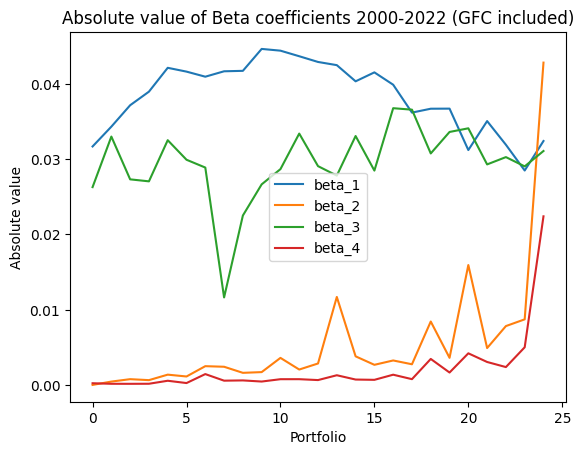

In [70]:
df_of_betas.abs().plot()
plt.title('Absolute value of Beta coefficients 1964-1999')
plt.xlabel('Portfolio')
plt.ylabel('Absolute value')
plt.show()

In [71]:
# We need the average illiquidity for each portfoilio in each year. Then we will use these averages per year to calculate an average for the entire period of 1964-1999 for each portfolio
df_non_market_for_portfolio_average = pd.DataFrame()
portfolio_numbers = list(range(0, 25))

for year in df_non_market_increasing_yearly_illiquidity_portfolios_returns:
    current_year_dictionary = df_non_market_increasing_yearly_illiquidity_portfolios_returns[year]
    current_year_array = np.ones(25)*year
    current_year_values_c = []
    current_year_values_ret = []

    for num in current_year_dictionary:
        current_year_num_portfolio = current_year_dictionary[num]
        average_c = current_year_num_portfolio['c'].mean()
        average_ret = current_year_num_portfolio['RET'].mean()
        current_year_values_c.append(average_c)
        current_year_values_ret.append(average_ret)

    df_for_current_year_portfolio_average = pd.DataFrame(current_year_values_c, columns=['average c'])
    df_for_current_year_portfolio_average['average RET'] = current_year_values_ret
    df_for_current_year_portfolio_average['year'] = current_year_array
    df_for_current_year_portfolio_average['number'] = portfolio_numbers
    df_for_current_year_portfolio_average = df_for_current_year_portfolio_average.set_index(['year', 'number'])

    df_non_market_for_portfolio_average = pd.concat([df_non_market_for_portfolio_average, df_for_current_year_portfolio_average], axis=0, join='outer')

        

In [72]:
df_non_market_for_portfolio_average

average c  average RET
year   number                        
2001.0 0        0.250040    -0.010668
       1        0.250108    -0.002382
       2        0.250212     0.005082
       3        0.250278     0.003174
       4        0.250762     0.004183
...                  ...          ...
2022.0 20       0.280462     0.015989
       21       0.299361     0.012364
       22       0.344955     0.007222
       23       0.404763    -0.000214
       24       0.695785     0.021087

[550 rows x 2 columns]

In [82]:
df_non_market_for_portfolio_average_grouped = df_non_market_for_portfolio_average.groupby(['number'])
overall_portfolio_average_values_c = []
overall_portfolio_average_values_ret = []
overall_portfolio_average_values_sigma_c = []
overall_portfolio_average_values_sigma_ret = []

for number, group in df_non_market_for_portfolio_average_grouped:
    col_c = group['average c']
    col_ret = group['average RET']
    average_c = col_c.mean()
    average_ret = col_ret.mean()
    sigma_c = col_c.std()
    sigma_ret = col_ret.std()
    overall_portfolio_average_values_c.append(average_c)
    overall_portfolio_average_values_ret.append(average_ret * 100)
    overall_portfolio_average_values_sigma_c.append(sigma_c * 100)
    overall_portfolio_average_values_sigma_ret.append(sigma_ret * 100)

df_non_market_overall_portfolio_average = pd.DataFrame(overall_portfolio_average_values_c, index=list(range(0, 25)), columns=['average c'])
df_non_market_overall_portfolio_average['sigma c'] = overall_portfolio_average_values_sigma_c
df_non_market_overall_portfolio_average['average RET'] = overall_portfolio_average_values_ret
df_non_market_overall_portfolio_average['sigma RET'] = overall_portfolio_average_values_sigma_ret

In [83]:
df_non_market_overall_portfolio_average

,average c,sigma c,average RET,sigma RET
0,0.250019,0.000743,0.409133,1.652176
1,0.250050,0.002727,0.587172,1.745086
2,0.250079,0.004126,0.544479,1.771712
3,0.250119,0.005545,0.636087,1.884312
4,0.250196,0.015596,0.756481,2.048009
5,0.250254,0.016531,0.851980,2.136547
6,0.250384,0.034195,0.768991,1.856291
7,0.250502,0.041097,0.711711,1.907650
8,0.251342,0.351761,1.102310,2.050549
9,0.250865,0.073544,0.924425,2.017871


In [84]:
#http://reliawiki.org/index.php/Multiple_Linear_Regression_Analysis#Example_2
lambdas=df_AMEX_NYSE_market_portfolios['RET']-df_AMEX_NYSE_market_portfolios['c']
lambdas=lambdas.loc[1964:]
t_stats=np.zeros([25,4]) 
mse=np.zeros(25)
for i in range(0,25):
    portfolio=arr_of_portfolios[i]
    beta_i=df_of_betas.iloc[i]
    y=portfolio['RET']-portfolio['c']
    
    y_hat=lambdas*(beta_i[0]+beta_i[1]-beta_i[2]-beta_i[3])
    n=len(y_hat)
    mse[i]=np.sum((y_hat-y)**2)/(n-5)
    std_err=np.sqrt(mse[i]/np.sum(lambdas**2))
    std_err=np.repeat(std_err,4)
    t_stats[i,:]=np.divide(beta_i,std_err)

In [85]:
dof=n-5
print(dof)
t_stats
df_t_stats = pd.DataFrame(t_stats, columns = df_of_betas.columns)
#critical value at 95% for two tail test with these degrees of freedom is +-1.1.996008
#outside this region reject null hypothesis that the given beta is 0
df_t_stats*100

271


,beta_1,beta_2,beta_3,beta_4
0,63.505949,-0.074839,-52.691208,-0.523162
1,69.855200,0.980837,-67.172242,-0.381958
2,75.107056,1.616780,-55.224357,-0.371410
3,78.955325,1.362233,-54.832635,-0.389009
4,86.292228,2.869174,-66.612684,-1.208655
5,84.710801,2.354752,-60.904201,-0.580539
6,83.763002,5.168254,-59.091956,-3.018917
7,83.149904,4.885848,-23.243317,-1.199852
8,84.843501,3.338500,-45.795674,-1.292348
9,91.036680,3.544892,-54.374119,-0.990889


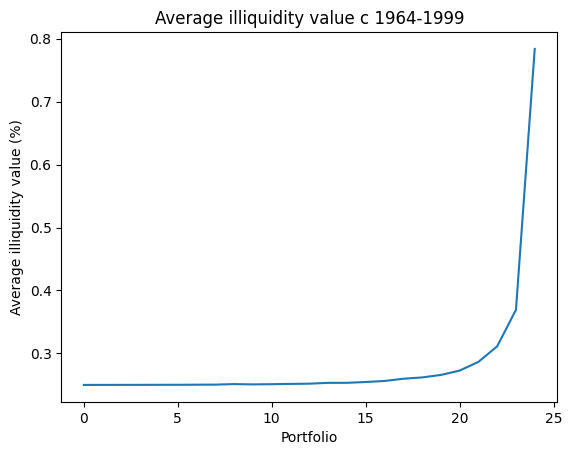

In [86]:
df_non_market_overall_portfolio_average['average c'].plot()
plt.title('Average illiquidity value c 1964-1999')
plt.xlabel('Portfolio')
plt.ylabel('Average illiquidity value (%)')
plt.show()

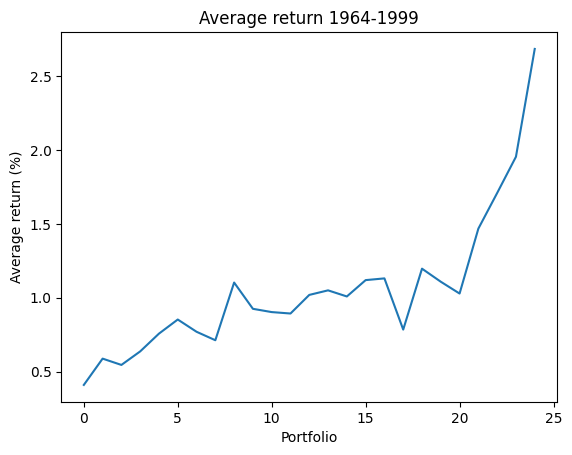

In [87]:
df_non_market_overall_portfolio_average['average RET'].plot()
plt.title('Average return 1964-1999')
plt.xlabel('Portfolio')
plt.ylabel('Average return (%)')
plt.show()